# 时序预测

In [1]:
import os
import tqdm
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import darts.models as models
import logging
from sklearn.metrics import mean_squared_error
from darts import TimeSeries

In [2]:
# 设置绘图风格
plt.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

In [3]:
# 编码格式为gb18030
day_data = pd.read_table("./HSI_日线数据.txt", encoding="gb18030", skiprows=1)
day_data = day_data.iloc[:-1]
day_data.columns = day_data.columns.str.strip()

In [4]:
series = TimeSeries.from_dataframe(day_data, value_cols=["收盘"], time_col="日期", freq="D")
series_df = series.pd_dataframe()
series_df = series_df.interpolate(method="linear")
# 按时间切片series_df
series_df = series_df.loc["2010-01-01":]
series = TimeSeries.from_dataframe(series_df)

In [5]:
week_series = series.resample("W").mean()
month_series = series.resample("M").mean()

In [6]:
def train_predict_model(series, start_day, end_day, model):
    train_range = pd.date_range(start=start_day, end=end_day, freq="D")
    train = series.slice(train_range[0], train_range[-1])
    model.fit(train)
    return model


def train_predict_model_week(series, start_day, end_day, model):
    train_range = pd.date_range(start=start_day, end=end_day, freq="W")
    train = series.slice(train_range[0], train_range[-1])
    model.fit(train)
    return model


def train_predict_model_month(series, start_day, end_day, model):
    train_range = pd.date_range(start=start_day, end=end_day, freq="M")
    train = series.slice(train_range[0], train_range[-1])
    model.fit(train)
    return model

In [7]:
"""
训练日线模型
"""

logging.disable(logging.CRITICAL)
exponential_day_model = train_predict_model(
    series, "2016-07-12", "2022-8-16", models.ExponentialSmoothing()
)
print("exponential model trained")

prophet_day_model = train_predict_model(
    series, "2016-07-12", "2022-8-16", models.Prophet()
)
print("prophet model trained")

autoARIMA_day_model = train_predict_model(
    series, "2016-07-12", "2022-8-16", models.StatsForecastAutoARIMA()
)
print("autoARIMA model trained")

TCN_day_model = train_predict_model(
    series,
    "2016-07-12",
    "2022-8-16",
    models.TCNModel(
        input_chunk_length=21,
        output_chunk_length=3,
        dropout=0.1,
        random_state=0,
        n_epochs=1000,
        model_name="TCN",
        batch_size=1024,
    ),
)
print("TCN model trained")

dlinear_day_model = train_predict_model(
    series,
    "2016-07-12",
    "2022-8-16",
    models.DLinearModel(
        input_chunk_length=21,
        output_chunk_length=3,
        random_state=0,
        n_epochs=1000,
        model_name="DLinear",
        batch_size=1024,
    ),
)
print("DLinear model trained")

TiDE_day_model = train_predict_model(
    series,
    "2016-07-12",
    "2022-8-16",
    models.TiDEModel(
        input_chunk_length=21,
        output_chunk_length=3,
        random_state=0,
        n_epochs=1000,
        model_name="TiDE",
        batch_size=1024,
    ),
)
print("TiDE model trained")

/home/ljx/anaconda3/envs/jasonye/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


exponential model trained
prophet model trained
autoARIMA model trained


/home/ljx/anaconda3/envs/jasonye/lib/python3.9/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 4 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


Training: |          | 0/? [00:00<?, ?it/s]

TCN model trained


Training: |          | 0/? [00:00<?, ?it/s]

DLinear model trained


Training: |          | 0/? [00:00<?, ?it/s]

TiDE model trained


In [31]:
exponential_day_model_pred = exponential_day_model.predict(14)
prophet_model_day_pred = prophet_day_model.predict(14)
autoARIMA_day_model_pred = autoARIMA_day_model.predict(14)
TCN_day_model_pred = TCN_day_model.predict(14)
dlinear_day_model_pred = dlinear_day_model.predict(14)
TiDE_day_model_pred = TiDE_day_model.predict(14)
day_train_range = pd.date_range(start="2016-07-12", end="2022-8-16", freq="D")
day_train = series.slice(day_train_range[0], day_train_range[-1])
actual_range = pd.date_range(start="2022-8-16", end="2022-8-29", freq="D")
day_actual = series.slice(actual_range[0], actual_range[-1])
print(len(day_actual))
# Calculate loss using actual values
mse_exponential_day_model = mean_squared_error(
    day_actual.values(), exponential_day_model_pred.values()
)
mse_prophet_day_model = mean_squared_error(
    day_actual.values(), prophet_model_day_pred.values()
)
mse_autoARIMA_day_model = mean_squared_error(
    day_actual.values(), autoARIMA_day_model_pred.values()
)
mse_TCN_day_model = mean_squared_error(day_actual.values(), TCN_day_model_pred.values())
mse_dlinear_day_model = mean_squared_error(
    day_actual.values(), dlinear_day_model_pred.values()
)
mse_TiDE_day_model = mean_squared_error(
    day_actual.values(), TiDE_day_model_pred.values()
)
print("mse_exponential_day_model:", mse_exponential_day_model)
print("mse_prophet_day_model:", mse_prophet_day_model)
print("mse_autoARIMA_day_model:", mse_autoARIMA_day_model)
print("mse_TCN_day_model:", mse_TCN_day_model)
print("mse_TiDE_day_model:", mse_TiDE_day_model)
print("mse_dlinear_day_model:", mse_dlinear_day_model)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

14
mse_exponential_day_model: 134020.4659139959
mse_prophet_day_model: 786935.0228476952
mse_autoARIMA_day_model: 57981.923877252804
mse_TCN_day_model: 600848.8353067125
mse_TiDE_day_model: 181160.2908206854
mse_dlinear_day_model: 74919.52721199932


Text(0, 0.5, 'HSI')

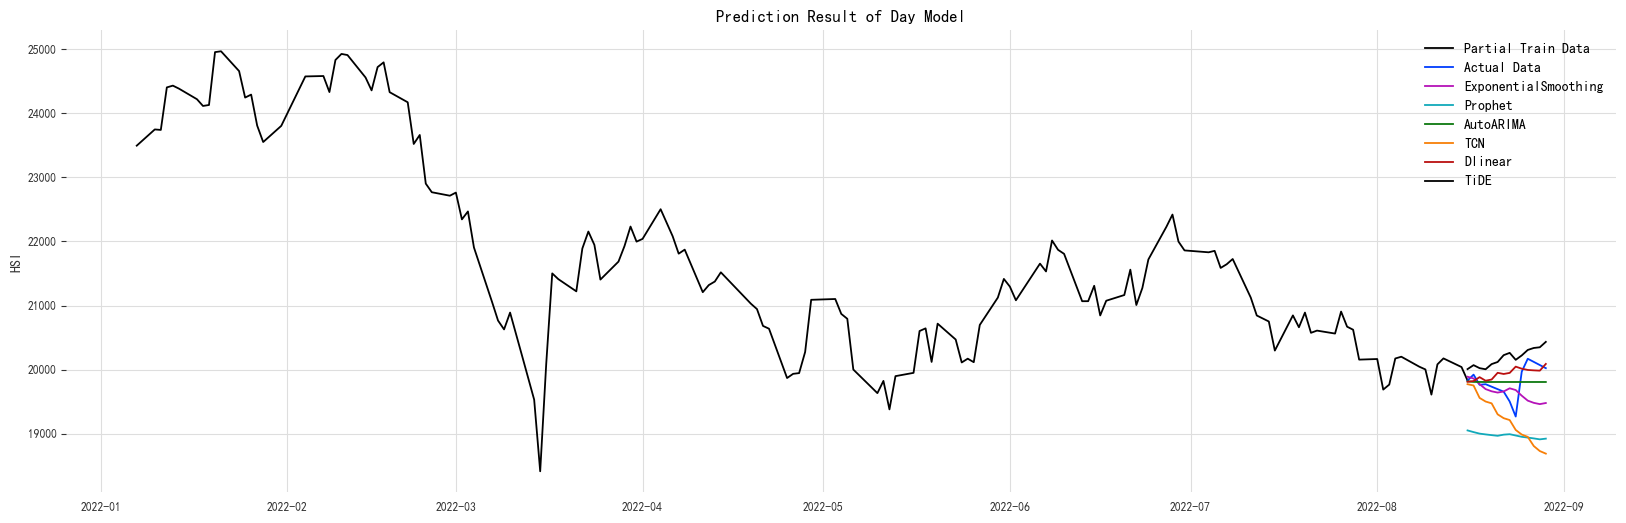

In [32]:
plt.figure(figsize=(20, 6))
# 只plot后面1/10的训练集
sub_train_range = day_train_range[-int(len(day_train_range) / 10) :]
sub_train = series.slice(sub_train_range[0], sub_train_range[-1])
plt.plot(sub_train_range, sub_train.values(), label="Partial Train Data")
plt.plot(actual_range, day_actual.values(), label="Actual Data")
plt.plot(
    actual_range, exponential_day_model_pred.values(), label="ExponentialSmoothing"
)
plt.plot(actual_range, prophet_model_day_pred.values(), label="Prophet")
plt.plot(actual_range, autoARIMA_day_model_pred.values(), label="AutoARIMA")
plt.plot(actual_range, TCN_day_model_pred.values(), label="TCN")
plt.plot(actual_range, dlinear_day_model_pred.values(), label="Dlinear")
plt.plot(actual_range, TiDE_day_model_pred.values(), label="TiDE")
plt.legend()
plt.title("Prediction Result of Day Model")
plt.ylabel("HSI")

In [10]:
"""
训练周线模型
"""
logging.disable(logging.CRITICAL)
exponential_week_model = train_predict_model_week(
    week_series, "2016-07-12", "2022-8-16", models.ExponentialSmoothing()
)
print("expontial model trained")
prophet_week_model = train_predict_model_week(
    week_series, "2016-07-12", "2022-8-16", models.Prophet()
)
print("prophet model trained")
autoARIMA_week_model = train_predict_model_week(
    week_series, "2016-07-12", "2022-8-16", models.StatsForecastAutoARIMA()
)
print("autoARIMA model trained")
TCN_week_model = train_predict_model_week(
    week_series,
    "2016-07-12",
    "2022-8-16",
    models.TCNModel(
        input_chunk_length=21,
        output_chunk_length=3,
        dropout=0.1,
        random_state=0,
        n_epochs=1000,
        model_name="TCN",
        batch_size=1024,
    ),
)
print("TCN model trained")
dlinear_week_model = train_predict_model_week(
    week_series,
    "2016-07-12",
    "2022-8-16",
    models.DLinearModel(
        input_chunk_length=21,
        output_chunk_length=3,
        random_state=0,
        n_epochs=1000,
        model_name="DLinear",
        batch_size=1024,
    ),
)
print("DLinear model trained")

TiDE_week_model = train_predict_model_week(
    week_series,
    "2016-07-12",
    "2022-8-16",
    models.TiDEModel(
        input_chunk_length=21,
        output_chunk_length=3,
        random_state=0,
        n_epochs=1000,
        model_name="TiDE",
        batch_size=1024,
    ),
)

/home/ljx/anaconda3/envs/jasonye/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


expontial model trained
prophet model trained
autoARIMA model trained


Training: |          | 0/? [00:00<?, ?it/s]

TCN model trained


Training: |          | 0/? [00:00<?, ?it/s]

DLinear model trained


Training: |          | 0/? [00:00<?, ?it/s]

In [51]:
exponential_week_model_pred = exponential_week_model.predict(7)
prophet_model_week_pred = prophet_week_model.predict(7)
autoARIMA_week_model_pred = autoARIMA_week_model.predict(7)
TCN_week_model_pred = TCN_week_model.predict(7)
dlinear_week_model_pred = dlinear_week_model.predict(7)
TiDE_week_model_pred = TiDE_week_model.predict(7)
week_train_range = pd.date_range(start="2016-07-12", end="2022-8-16", freq="W")
week_train = week_series.slice(week_train_range[0], week_train_range[-1])
week_actual_range = pd.date_range(start="2022-8-16", end="2022-10-6", freq="W")
week_actual = week_series.slice(week_actual_range[0], week_actual_range[-1])
print(len(week_actual))
# 通过actual计算loss
mse_exponential_week_model = mean_squared_error(
    week_actual.values(), exponential_week_model_pred.values()
)
mse_prophet_week_model = mean_squared_error(
    week_actual.values(), prophet_model_week_pred.values()
)
mse_autoARIMA_week_model = mean_squared_error(
    week_actual.values(), autoARIMA_week_model_pred.values()
)
mse_TCN_week_model = mean_squared_error(
    week_actual.values(), TCN_week_model_pred.values()
)
mse_dlinear_week_model = mean_squared_error(
    week_actual.values(), dlinear_week_model_pred.values()
)
mse_TiDE_week_model = mean_squared_error(
    week_actual.values(), TiDE_week_model_pred.values()
)
print("mse_exponential_week_model:", mse_exponential_week_model)
print("mse_prophet_week_model:", mse_prophet_week_model)
print("mse_autoARIMA_week_model:", mse_autoARIMA_week_model)
print("mse_TCN_week_model:", mse_TCN_week_model)
print("mse_TiDE_week_model:", mse_TiDE_week_model)
print("mse_dlinear_week_model:", mse_dlinear_week_model)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

7
mse_exponential_week_model: 947142.446305884
mse_prophet_week_model: 313582.36145927396
mse_autoARIMA_week_model: 2435162.4580718228
mse_TCN_week_model: 379416.70665116806
mse_TiDE_week_model: 1943157.718410361
mse_dlinear_week_model: 2139071.3418208077


Text(0.5, 1.0, 'Prediction Result of Week Model')

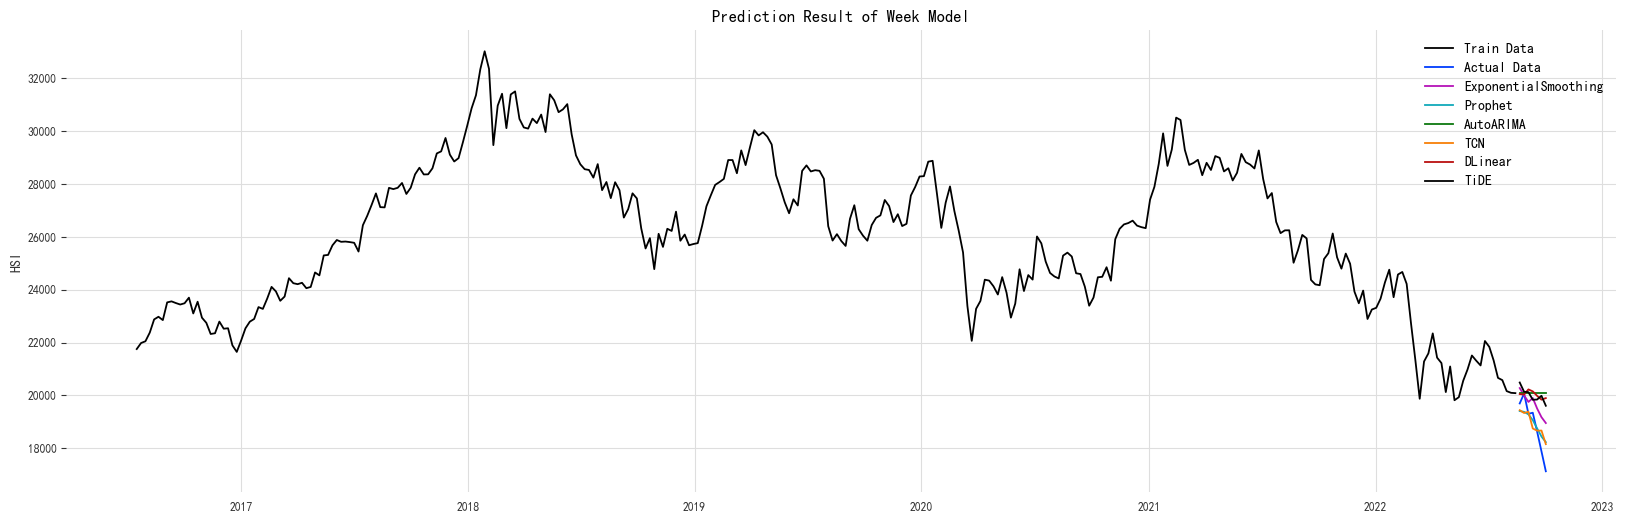

In [52]:
plt.figure(figsize=(20, 6))
plt.plot(week_train_range, week_train.values(), label="Train Data")
plt.plot(week_actual_range, week_actual.values(), label="Actual Data")
plt.plot(
    week_actual_range,
    exponential_week_model_pred.values(),
    label="ExponentialSmoothing",
)
plt.plot(week_actual_range, prophet_model_week_pred.values(), label="Prophet")
plt.plot(week_actual_range, autoARIMA_week_model_pred.values(), label="AutoARIMA")
plt.plot(week_actual_range, TCN_week_model_pred.values(), label="TCN")
plt.plot(week_actual_range, dlinear_week_model_pred.values(), label="DLinear")
plt.plot(week_actual_range, TiDE_week_model_pred.values(), label="TiDE")
plt.legend()
plt.ylabel("HSI")
plt.title("Prediction Result of Week Model")

In [13]:
"""
训练月线模型
"""
logging.disable(logging.CRITICAL)
exponential_month_model = train_predict_model_month(
    month_series, "2016-07-12", "2021-8-16", models.ExponentialSmoothing()
)
print("expontial model trained")
prophet_month_model = train_predict_model_month(
    month_series, "2016-07-12", "2021-8-16", models.Prophet()
)
print("prophet model trained")
autoARIMA_month_model = train_predict_model_month(
    month_series, "2016-07-12", "2021-8-16", models.StatsForecastAutoARIMA()
)
print("autoARIMA model trained")
TCN_month_model = train_predict_model_month(
    month_series,
    "2016-07-12",
    "2021-8-16",
    models.TCNModel(
        kernel_size=2,
        input_chunk_length=4,
        output_chunk_length=2,
        random_state=0,
        n_epochs=1000,
        model_name="TCN",
        batch_size=1024,
    ),
)
print("TCN model trained")
dlinear_month_model = train_predict_model_month(
    month_series,
    "2016-07-12",
    "2021-8-16",
    models.DLinearModel(
        input_chunk_length=4,
        output_chunk_length=2,
        random_state=0,
        n_epochs=1000,
        model_name="DLinear",
        batch_size=1024,
    ),
)
print("DLinear model trained")
TiDE_month_model = train_predict_model_month(
    month_series,
    "2016-07-12",
    "2021-8-16",
    models.TiDEModel(
        input_chunk_length=4,
        output_chunk_length=2,
        random_state=0,
        n_epochs=1000,
        model_name="TiDE",
        batch_size=1024,
    ),
)

expontial model trained
prophet model trained
autoARIMA model trained


Training: |          | 0/? [00:00<?, ?it/s]

TCN model trained


Training: |          | 0/? [00:00<?, ?it/s]

DLinear model trained


Training: |          | 0/? [00:00<?, ?it/s]

In [36]:
exponential_month_model_pred = exponential_month_model.predict(3)
prophet_model_month_pred = prophet_month_model.predict(3)
autoARIMA_month_model_pred = autoARIMA_month_model.predict(3)
TCN_month_model_pred = TCN_month_model.predict(3)
dlinear_month_model_pred = dlinear_month_model.predict(3)
TiDE_month_model_pred = TiDE_month_model.predict(3)
month_train_range = pd.date_range(start="2016-07-12", end="2021-8-16", freq="M")
month_train = month_series.slice(month_train_range[0], month_train_range[-1])
month_actual_range = pd.date_range(start="2021-8-16", end="2021-11-21", freq="M")
month_actual = month_series.slice(month_actual_range[0], month_actual_range[-1])
print(len(month_actual))
mse_exponential_month_model = mean_squared_error(
    month_actual.values(), exponential_month_model_pred.values()
)
mse_prophet_month_model = mean_squared_error(
    month_actual.values(), prophet_model_month_pred.values()
)
mse_autoARIMA_month_model = mean_squared_error(
    month_actual.values(), autoARIMA_month_model_pred.values()
)
mse_TCN_month_model = mean_squared_error(
    month_actual.values(), TCN_month_model_pred.values()
)
mse_dlinear_month_model = mean_squared_error(
    month_actual.values(), dlinear_month_model_pred.values()
)
mse_TiDE_month_model = mean_squared_error(
    month_actual.values(), TiDE_month_model_pred.values()
)
print("mse_exponential_month_model:", mse_exponential_month_model)
print("mse_prophet_month_model:", mse_prophet_month_model)
print("mse_autoARIMA_month_model:", mse_autoARIMA_month_model)
print("mse_TCN_month_model:", mse_TCN_month_model)
print("mse_TiDE_month_model:", mse_TiDE_month_model)
print("mse_dlinear_month_model:", mse_dlinear_month_model)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

3
mse_exponential_month_model: 782600.2971150653
mse_prophet_month_model: 160617.59885738837
mse_autoARIMA_month_model: 840223.030710443
mse_TCN_month_model: 1906632.2748156693
mse_TiDE_month_model: 955577.0649294859
mse_dlinear_month_model: 1327488.12083723


Text(0.5, 1.0, 'Prediction Result of Month Model')

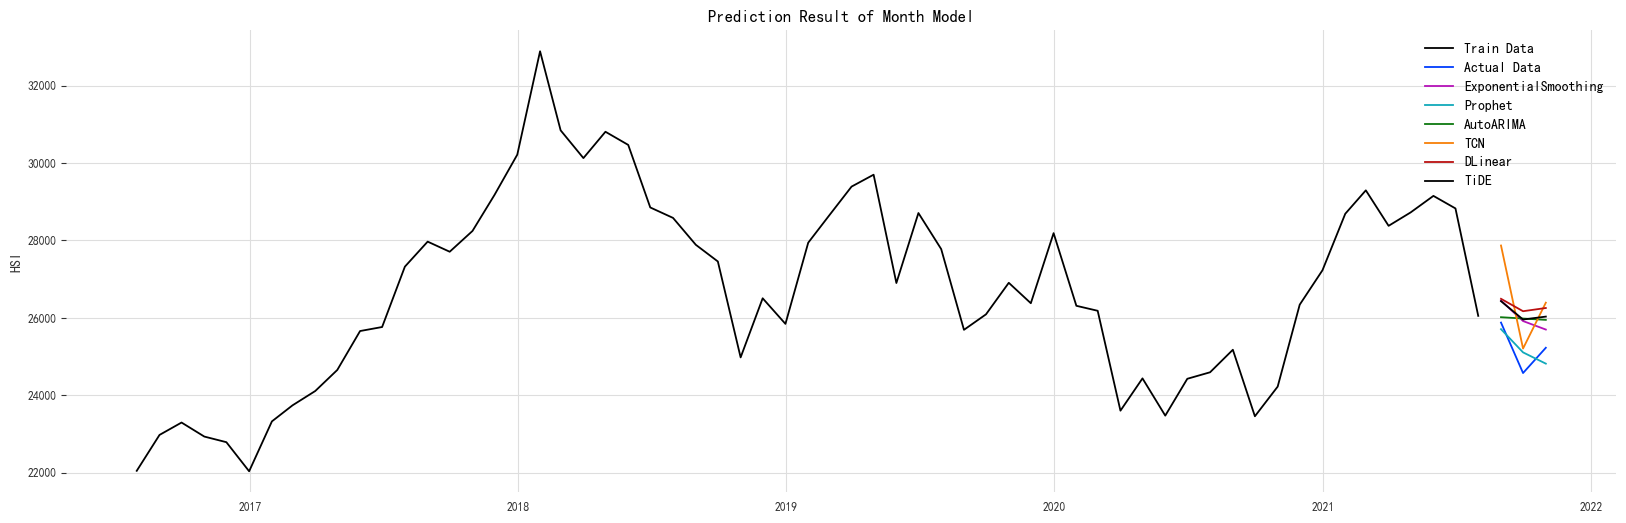

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(month_train_range, month_train.values(), label="Train Data")
plt.plot(month_actual_range, month_actual.values(), label="Actual Data")
plt.plot(
    month_actual_range,
    exponential_month_model_pred.values(),
    label="ExponentialSmoothing",
)
plt.plot(month_actual_range, prophet_model_month_pred.values(), label="Prophet")
plt.plot(month_actual_range, autoARIMA_month_model_pred.values(), label="AutoARIMA")
plt.plot(month_actual_range, TCN_month_model_pred.values(), label="TCN")
plt.plot(month_actual_range, dlinear_month_model_pred.values(), label="DLinear")
plt.plot(month_actual_range, TiDE_month_model_pred.values(), label="TiDE")
plt.legend()
plt.ylabel("HSI")
plt.title("Prediction Result of Month Model")